# 1. Reading in the data

In [1]:
import pandas as pd

In [2]:
# read in full_data.parquet as a df called df_linec
df_linec = pd.read_parquet('full_data.parquet')

In [3]:
df_linec.head()

,SESSION_DATE,SniffTime,age,ReadTotalSnifftime,id_rat,rat_name,birth_date,gender,weight,temperature,id_sample,tb,hit,match_flag,SniffThreshold'
0,2016-11-03 00:00:00,0,2.0,None,98.0,Stephen,2014-07-21,M,NaN,30.5,515562,False,False,None,0.0
1,2016-11-03 00:00:00,0,2.0,None,98.0,Stephen,2014-07-21,M,NaN,30.5,515546,False,False,None,0.0
2,2016-11-03 00:00:00,0,2.0,None,98.0,Stephen,2014-07-21,M,NaN,30.5,515422,False,False,None,0.0
3,2016-11-03 00:00:00,0,2.0,None,98.0,Stephen,2014-07-21,M,NaN,30.5,515559,False,False,None,0.0
4,2016-11-03 00:00:00,0,2.0,None,98.0,Stephen,2014-07-21,M,NaN,30.5,515553,False,False,None,0.0


In [4]:
# make a list of all unique session date values
session_dates = df_linec['SESSION_DATE'].unique()
print(f"Unique SESSION_DATE values: {session_dates}")


Unique SESSION_DATE values: ['2016-11-03 00:00:00' '2016-09-01 00:00:00' '2016-09-05 00:00:00'
 '2016-09-07 00:00:00' '2016-09-02 00:00:00' '2016-09-06 00:00:00'
 '2016-09-08 00:00:00' '2016-09-15 00:00:00' '2016-09-16 00:00:00'
 '2016-09-09 00:00:00' '2016-09-13 00:00:00' '2016-09-14 00:00:00'
 '2016-09-20 00:00:00' '2016-09-21 00:00:00' '2016-09-22 00:00:00'
 '2016-09-29 00:00:00' '2016-09-27 00:00:00' '2016-09-28 00:00:00'
 '2016-10-03 00:00:00' '2016-10-05 00:00:00' '2016-10-06 00:00:00'
 '2016-10-07 00:00:00' '2016-10-13 00:00:00' '2016-09-30 00:00:00'
 '2016-10-18 00:00:00' '2016-10-20 00:00:00' '2016-10-24 00:00:00'
 '2016-09-26 00:00:00' '2016-10-10 00:00:00' '2016-10-11 00:00:00'
 '2016-10-12 00:00:00' '2016-10-17 00:00:00' '2016-10-19 00:00:00'
 '2016-12-01 00:00:00' '2016-10-21 00:00:00' '2016-10-28 00:00:00'
 '2016-12-02 00:00:00' '2016-12-05 00:00:00' '2016-12-06 00:00:00'
 '2016-10-31 00:00:00' '2016-11-01 00:00:00' '2016-11-02 00:00:00'
 '2016-11-29 00:00:00' '2019-03-15

In [5]:
import pandas as pd
import numpy as np

def convert_mixed_dates(val):
    try:
        # If numeric (int/float), treat as Excel serial
        if isinstance(val, (int, float, np.integer, np.floating)):
            return pd.to_datetime('1899-12-30') + pd.to_timedelta(val, unit='D')
        # If string, check if it’s numeric (Excel serial stored as string)
        elif val.isdigit():
            return pd.to_datetime('1899-12-30') + pd.to_timedelta(int(val), unit='D')
        else:
            # Else, try to parse normally
            return pd.to_datetime(val, errors='coerce', infer_datetime_format=True)
    except:
        return pd.NaT

df_linec["SESSION_DATE"] = df_linec["SESSION_DATE"].apply(convert_mixed_dates)


C:\Users\ValentinJanclaes\AppData\Local\Temp\ipykernel_9152\2523619785.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(val, errors='coerce', infer_datetime_format=True)


In [6]:
# make a list of all unique session date values
session_dates = df_linec['SESSION_DATE'].unique()
print(f"Unique SESSION_DATE values: {session_dates}")


Unique SESSION_DATE values: <DatetimeArray>
['2016-11-03 00:00:00', '2016-09-01 00:00:00', '2016-09-05 00:00:00',
 '2016-09-07 00:00:00', '2016-09-02 00:00:00', '2016-09-06 00:00:00',
 '2016-09-08 00:00:00', '2016-09-15 00:00:00', '2016-09-16 00:00:00',
 '2016-09-09 00:00:00',
 ...
 '2024-09-13 00:00:00', '2024-09-17 00:00:00', '2024-09-18 00:00:00',
 '2024-09-19 00:00:00', '2024-09-20 00:00:00', '2024-09-24 00:00:00',
 '2024-09-25 00:00:00', '2024-09-26 00:00:00', '2024-09-27 00:00:00',
 '2024-09-30 00:00:00']
Length: 298, dtype: datetime64[ns]


# 2. Profiling the rats

In [7]:
import pandas as pd
from typing import Literal

def fill_weights_day_level(
    df: pd.DataFrame,
    name_col: str = "rat_name",
    date_col: str = "SESSION_DATE",
    weight_col: str = "weight",
    agg: Literal["mean", "first"] = "mean"
) -> pd.DataFrame:
    """
    Return a copy of df where missing WEIGHT values are filled on a day-level:
      - Leading days (before first known) are filled with first known weight.
      - Trailing days (after last known) are filled with last known weight.
      - Internal missing days are linearly interpolated based on calendar days.
    The original rows are preserved; only WEIGHT is filled where missing.
    """
    df = df.copy()
    # normalize to midnight datetimes so we have proper DatetimeIndex behavior
    df[date_col] = pd.to_datetime(df[date_col]).dt.normalize()

    # choose aggregator for days (mean or first)
    agg_func = "mean" if agg == "mean" else "first"

    filled_mappings = []  # will collect per-name mappings (date -> filled weight)

    for name, g in df.groupby(name_col):
        # daily aggregated known values (only for dates that exist in raw data)
        daily_known = g.groupby(date_col)[weight_col].agg(agg_func)
        # ensure index is DatetimeIndex normalized
        daily_known.index = pd.to_datetime(daily_known.index).normalize()

        start = g[date_col].min()
        end = g[date_col].max()
        full_idx = pd.date_range(start, end, freq="D")

        # series with full calendar index for this rat
        day_series = pd.Series(index=full_idx, dtype=float)
        # assign known values (days that had rows; may be NaN if all rows that day were NaN)
        day_series.loc[daily_known.index] = daily_known.values

        # find first/last actual known (non-NaN) values
        first_valid = day_series.first_valid_index()
        last_valid = day_series.last_valid_index()

        if first_valid is None:
            # No known weights at all for this rat: leave NaNs (nothing to interpolate/propagate)
            # Map back to rows so merge keeps alignment
            mapping = pd.DataFrame({
                date_col: g[date_col].unique(),
                name_col: name,
                "WEIGHT_FILLED": [float("nan")] * g[date_col].nunique()
            })
            filled_mappings.append(mapping)
            continue

        # Fill leading days (before first_known) with first_known, and trailing after last_known with last_known
        # (this only affects outside the known-range)
        day_series.loc[:first_valid] = day_series.loc[first_valid]
        day_series.loc[last_valid:] = day_series.loc[last_valid]

        # Now interpolate only the internal NaNs using time-aware interpolation
        day_series = day_series.interpolate(method="time")

        # Build mapping DataFrame for dates that actually exist in g
        unique_dates = pd.Series(g[date_col].unique()).dt.normalize()
        mapping = pd.DataFrame({date_col: unique_dates})
        mapping[name_col] = name
        # map date -> interpolated day weight
        mapping["WEIGHT_FILLED"] = mapping[date_col].map(day_series)
        filled_mappings.append(mapping)

    # combine mappings and merge back to original
    mapping_all = pd.concat(filled_mappings, ignore_index=True)
    # ensure datatypes align for merge
    mapping_all[date_col] = pd.to_datetime(mapping_all[date_col]).dt.normalize()
    df = df.merge(mapping_all, on=[name_col, date_col], how="left")

    # fill original WEIGHT only where missing
    df[weight_col] = df[weight_col].fillna(df["WEIGHT_FILLED"])
    df = df.drop(columns=["WEIGHT_FILLED"])

    return df


In [8]:
# Make sure SESSION_DATE is datetime and WEIGHT is numeric
df_linec["SESSION_DATE"] = pd.to_datetime(df_linec["SESSION_DATE"])
df_linec["weight"] = pd.to_numeric(df_linec["weight"], errors="coerce")

# Apply the function from above
df_linec_filled = fill_weights_day_level(
    df_linec,
    name_col="rat_name",
    date_col="SESSION_DATE",
    weight_col="weight",
    agg="first"   # or "mean" if you prefer daily average
)

# Now df_linec_filled has WEIGHT filled on day-level


In [9]:
df_linec_filled.head()

,SESSION_DATE,SniffTime,age,ReadTotalSnifftime,id_rat,rat_name,birth_date,gender,weight,temperature,id_sample,tb,hit,match_flag,SniffThreshold'
0,2016-11-03,0,2.0,None,98.0,Stephen,2014-07-21,M,866.428571,30.5,515562,False,False,None,0.0
1,2016-11-03,0,2.0,None,98.0,Stephen,2014-07-21,M,866.428571,30.5,515546,False,False,None,0.0
2,2016-11-03,0,2.0,None,98.0,Stephen,2014-07-21,M,866.428571,30.5,515422,False,False,None,0.0
3,2016-11-03,0,2.0,None,98.0,Stephen,2014-07-21,M,866.428571,30.5,515559,False,False,None,0.0
4,2016-11-03,0,2.0,None,98.0,Stephen,2014-07-21,M,866.428571,30.5,515553,False,False,None,0.0


In [10]:
# check if any weights are still missing
missing_weights = df_linec_filled['weight'].isnull().sum()
print(f"Number of missing WEIGHT entries after filling: {missing_weights}")

Number of missing WEIGHT entries after filling: 205370


In [11]:
# delete all columns but Birthdate, Gender, WEIGHT and TB
df_linec_filled = df_linec_filled[['age', 'gender','temperature', 'weight', 'tb', 'hit']]
df_linec_filled.head()

,age,gender,temperature,weight,tb,hit
0,2.0,M,30.5,866.428571,False,False
1,2.0,M,30.5,866.428571,False,False
2,2.0,M,30.5,866.428571,False,False
3,2.0,M,30.5,866.428571,False,False
4,2.0,M,30.5,866.428571,False,False


In [13]:

# Convert 'gender' to binary if it's not already numeric
if df_linec_filled['gender'].dtype == 'object':
    df_linec_filled['gender'] = df_linec_filled['gender'].map({'F': 0, 'M': 1})


In [15]:
# Create the 'correct_prediction' column
df_linec_filled["correct_prediction"] = (df_linec_filled["tb"] == df_linec_filled["hit"]).astype(int)


# 3. Visualisations


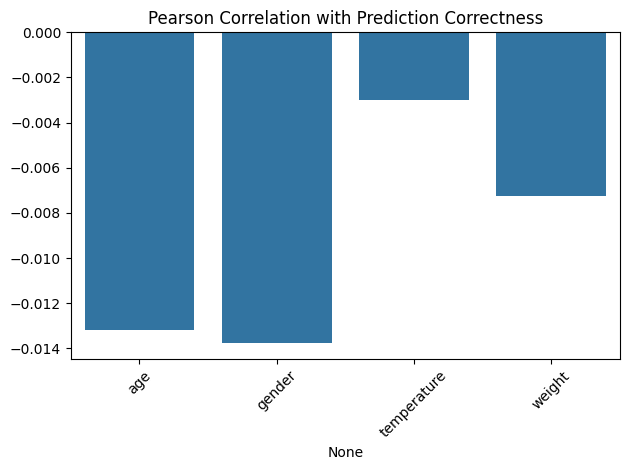

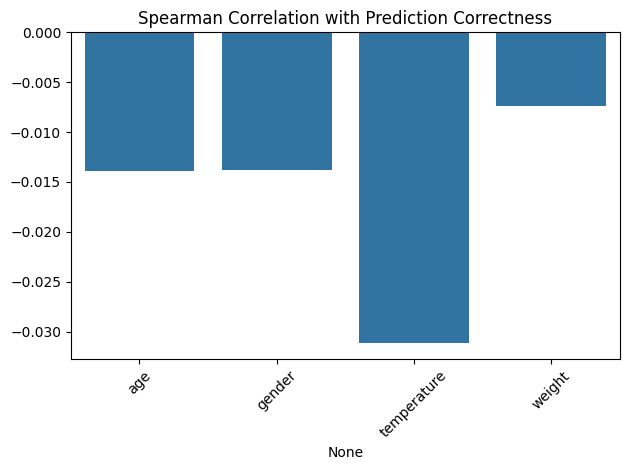

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation
pearson_corr = df_linec_filled.corr(method="pearson")["correct_prediction"].drop(["correct_prediction", "hit", "tb"])
sns.barplot(x=pearson_corr.index, y=pearson_corr.values)
plt.xticks(rotation=45)
plt.title("Pearson Correlation with Prediction Correctness")
plt.tight_layout()
plt.show()

# Spearman correlation
spearman_corr = df_linec_filled.corr(method="spearman")["correct_prediction"].drop(["correct_prediction", "hit", "tb"])
sns.barplot(x=spearman_corr.index, y=spearman_corr.values)
plt.xticks(rotation=45)
plt.title("Spearman Correlation with Prediction Correctness")
plt.tight_layout()
plt.show()

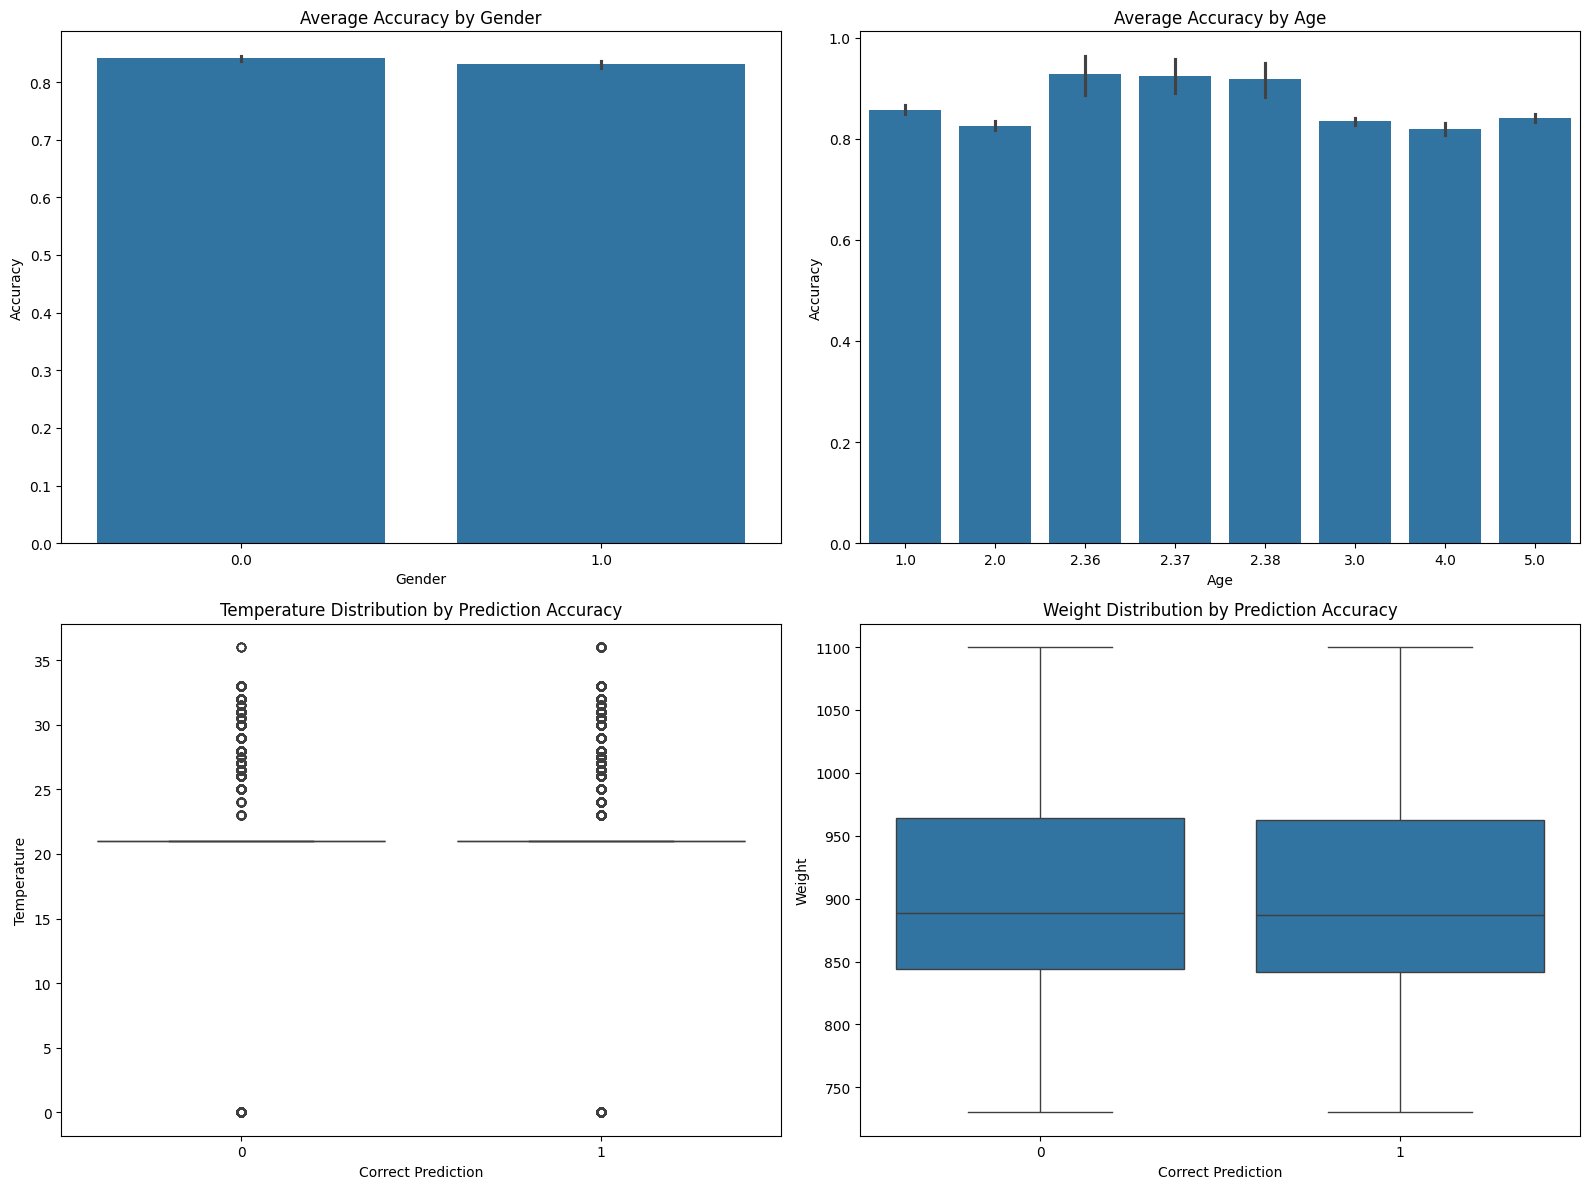

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the correct_prediction column
df_linec_filled["correct_prediction"] = (df_linec_filled["tb"] == df_linec_filled["hit"]).astype(int)

# Define demographic features to analyze
demographic_features = ["gender", "age", "temperature", "weight"]

# Set up the plotting area
plt.figure(figsize=(16, 12))

# Generate plots for each demographic feature
for i, feature in enumerate(demographic_features, 1):
    plt.subplot(2, 2, i)
    
    if df_linec_filled[feature].nunique() <= 10 or df_linec_filled[feature].dtype == "object":
        # Use barplot for categorical or low-cardinality features
        sns.barplot(x=feature, y="correct_prediction", data=df_linec_filled)
        plt.title(f"Average Accuracy by {feature.capitalize()}")
        plt.ylabel("Accuracy")
        plt.xlabel(feature.capitalize())
    else:
        # Use boxplot for continuous features
        sns.boxplot(x="correct_prediction", y=feature, data=df_linec_filled)
        plt.title(f"{feature.capitalize()} Distribution by Prediction Accuracy")
        plt.xlabel("Correct Prediction")
        plt.ylabel(feature.capitalize())

plt.tight_layout()
plt.show()

In [ ]:

def categorize_individuals(df):
    categories = {
        'high_recall': [],
        'high_specificity': [],
        'high_precision': [],
        'low_false_negative_rate': []
    }

    individuals = df['rat_name'].unique()

    for person in individuals:
        sub_df = df[df['rat_name'] == person]
        y_true = sub_df['tb']
        y_pred = sub_df['hit']

        # Compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        # Compute metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 1

        # Categorize based on thresholds
        if recall >= 0.8:
            categories['high_recall'].append(person)
        if specificity >= 0.8:
            categories['high_specificity'].append(person)
        if precision >= 0.8:
            categories['high_precision'].append(person)
        if false_negative_rate <= 0.2:
            categories['low_false_negative_rate'].append(person)

    return categories
